# Car Wash Volume Prediction Model
## Complete Production-Ready Implementation

**Model:** Random Forest Regressor  
**Performance:** 27% correlation, 32% within-30% accuracy  

---
## Table of Contents
1. [Setup & Data Loading](#setup)
2. [Exploratory Data Analysis](#eda)
3. [Data Preprocessing](#preprocessing)
4. [Model Training](#training)
5. [Model Evaluation](#evaluation)
6. [Feature Importance](#features)
7. [SHAP-Style Explanations](#shap)
8. [Making Predictions](#predictions)
9. [Production Usage Examples](#examples)

---
## 1. Setup & Data Loading <a id='setup'></a>

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings('ignore')

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', '{:.2f}'.format)

# Set random seed for reproducibility
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

print("✅ Libraries imported successfully")

✅ Libraries imported successfully


In [5]:
# Load dataset
# NOTE: Update this path to your data file location
df = pd.read_excel('dataSET__1_.xlsx')

# Sanity check: expected 531 locations (car wash sites)
EXPECTED_ROWS = 531
assert len(df) == EXPECTED_ROWS, f"Expected {EXPECTED_ROWS} rows, got {len(df)}. Check data file."
print(f"Dataset shape: {df.shape}")
print(f"\nColumns: {len(df.columns)}")
print(f"Rows: {len(df)} (expected {EXPECTED_ROWS} ✓)")

# Display first few rows
df.head()

Dataset shape: (531, 52)

Columns: 52
Rows: 531


,full_site_address,Nearest StreetLight US Hourly-Ttl AADT,2nd Nearest StreetLight US Hourly-Ttl AADT,3rd Nearest StreetLight US Hourly-Ttl AADT,4th Nearest StreetLight US Hourly-Ttl AADT,5th Nearest StreetLight US Hourly-Ttl AADT,6th Nearest StreetLight US Hourly-Ttl AADT,Nearest StreetLight US Hourly-ttl_breakfast,Nearest StreetLight US Hourly-ttl_lunch,Nearest StreetLight US Hourly-ttl_afternoon,Nearest StreetLight US Hourly-ttl_dinner,Nearest StreetLight US Hourly-ttl_night,Nearest StreetLight US Hourly-ttl_overnight,Count of ChainXY VT - Building Supplies,Count of ChainXY VT - Department Store,Count of ChainXY VT - Grocery,Count of ChainXY VT - Mass Merchant,Count of ChainXY VT - Real Estate Model,Sum ChainXY,total_weekly_operational_hours,nearby_traffic_lights_count,distance_nearest_traffic_light_1,distance_nearest_traffic_light_2,distance_nearest_traffic_light_3,distance_nearest_traffic_light_4,distance_nearest_traffic_light_5,distance_nearest_traffic_light_6,distance_nearest_traffic_light_7,distance_nearest_traffic_light_8,distance_nearest_traffic_light_9,distance_nearest_traffic_light_10,total_precipitation_mm,rainy_days,total_snowfall_cm,snowy_days,days_below_freezing,total_sunshine_hours,days_pleasant_temp,avg_daily_max_windspeed_ms,competitors_count,competitor_1_distance_miles,competitor_1_google_user_rating_count,tunnel_length (in ft.),distance_from_nearest_target,count_of_target_5miles,distance_from_nearest_costco,count_of_costco_5miles,distance_from_nearest_walmart,count_of_walmart_5miles,distance_from_nearest_bestbuy,count_of_bestbuy_5miles,cars_washed(Actual)
0,"*** stonewash *** car care center , 818 paris ...",8238,8742,221,8438,345,8697,1885,1950,1977,1565,722,115,1,0,0,1,0,2,57.00,14,0.15,0.17,0.49,0.56,0.63,0.64,0.67,0.70,0.71,1.14,1319.41,121.60,17.41,10.00,49.10,3163.84,126.10,15.50,1,0.03,51,0.00,NaN,0.00,NaN,0.00,0.81,1.00,NaN,0.00,36381
1,"a-key car wash , 2210 n prince st , clovis , n...",14416,14543,11548,13583,12386,10335,2723,3373,3328,3064,1590,322,1,1,0,1,0,3,75.50,29,0.13,0.20,0.22,0.38,0.50,0.63,0.74,0.79,0.84,0.88,326.92,48.10,23.55,13.60,59.60,3751.92,131.40,24.57,4,0.51,1,86.06,NaN,0.00,NaN,0.00,1.15,1.00,NaN,0.00,95400
2,"washpointe auto wash , 1401 n prince st , clov...",11553,3057,3513,12675,11520,3253,2221,2532,2634,2455,1373,314,1,1,0,1,0,3,67.50,30,0.04,0.32,0.40,0.47,0.53,0.54,0.60,0.71,0.75,0.80,326.92,48.10,23.55,13.60,59.20,3751.92,131.30,24.57,2,0.40,1,61.02,NaN,0.00,NaN,0.00,1.75,1.00,NaN,0.00,14343
3,"all star car wash , 5835 n market st , shrevep...",16857,16882,16757,3888,13385,4551,4388,3119,3676,3436,1613,605,0,0,0,1,0,1,0.00,4,0.13,0.16,0.54,0.68,10.00,10.00,10.00,10.00,10.00,10.00,1347.06,118.10,4.38,1.50,12.30,3207.54,140.20,16.90,0,10.00,0,0.00,NaN,0.00,NaN,0.00,NaN,0.00,NaN,0.00,10751
4,"abercorn , 10509 abercorn st , savannah , ga ,...",9739,12420,2202,10193,12491,2489,1558,2162,2351,2080,1215,364,2,2,3,1,1,9,77.00,30,0.14,0.25,0.26,0.30,0.43,0.51,0.55,0.67,0.72,0.88,1314.13,139.40,0.37,0.10,3.30,3385.14,166.10,19.37,3,0.45,185,166.18,2.46,1.00,NaN,0.00,2.42,2.00,1.30,1.00,12326


---
## 2. Exploratory Data Analysis <a id='eda'></a>

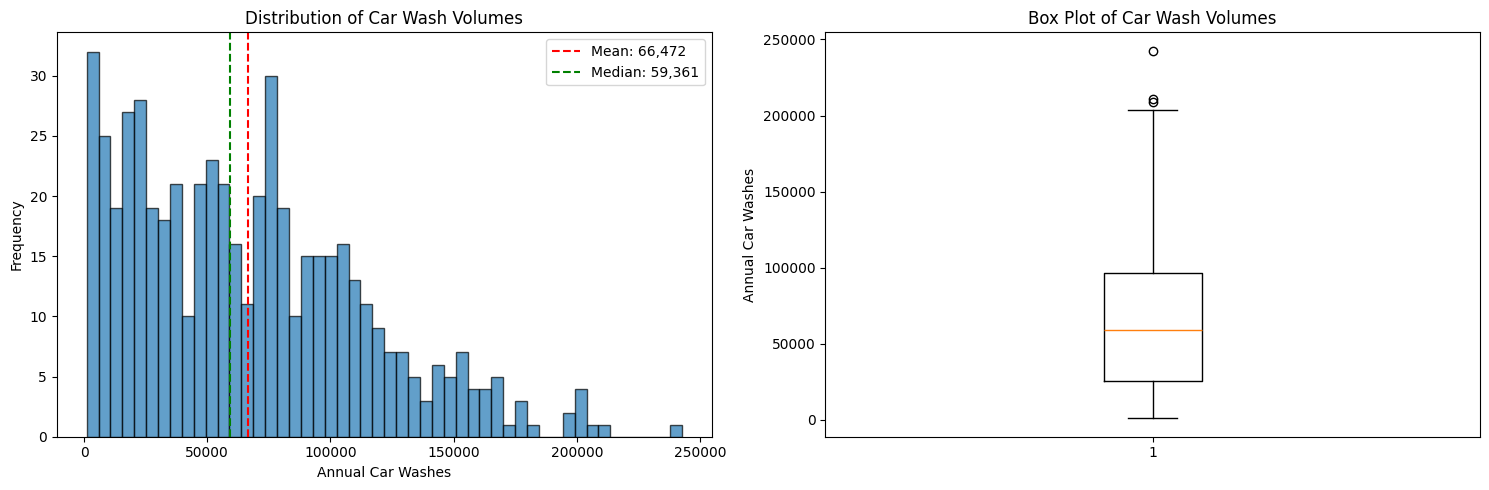

In [8]:
# Visualize target distribution
target = 'cars_washed(Actual)'
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Histogram
axes[0].hist(df[target], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('Annual Car Washes')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Car Wash Volumes')
axes[0].axvline(df[target].mean(), color='red', linestyle='--', label=f'Mean: {df[target].mean():,.0f}')
axes[0].axvline(df[target].median(), color='green', linestyle='--', label=f'Median: {df[target].median():,.0f}')
axes[0].legend()

# Box plot
axes[1].boxplot(df[target], vert=True)
axes[1].set_ylabel('Annual Car Washes')
axes[1].set_title('Box Plot of Car Wash Volumes')

plt.tight_layout()
plt.show()


In [9]:
# Check missing values
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)

if len(missing) > 0:
    print("="*80)
    print("MISSING VALUES")
    print("="*80)
    for col, count in missing.items():
        pct = (count / len(df)) * 100
        print(f"{col:<50s} {count:>5d} ({pct:>5.1f}%)")
else:
    print("✅ No missing values in dataset")

MISSING VALUES
distance_from_nearest_costco                         465 ( 87.6%)
distance_from_nearest_bestbuy                        439 ( 82.7%)
distance_from_nearest_target                         349 ( 65.7%)
distance_from_nearest_walmart                         72 ( 13.6%)
tunnel_length (in ft.)                                 1 (  0.2%)
count_of_target_5miles                                 1 (  0.2%)
count_of_costco_5miles                                 1 (  0.2%)
count_of_walmart_5miles                                1 (  0.2%)
count_of_bestbuy_5miles                                1 (  0.2%)


**Recommendation: Imputation, not extrapolation**

- **Extrapolation** (estimating distances from external data or models) is usually not worth it: it adds complexity, can introduce bias, and your missingness likely means "no store in range" or "not collected," not "we can guess the value."
- **Imputation** is the right approach:
  - **Low missing (0.2%–13.6%):** Fill with **median** — standard and safe.
  - **High missing (65%–88%):** For `distance_from_nearest_*`, missing often means "far" or "no store found." Options:
    1. **Keep median imputation** (what you do later) — simple; the model uses "typical distance" where missing.
    2. **Optional:** Add **missingness indicators** (e.g. `costco_distance_missing`) so the model can use "missing" as a signal (e.g. "no Costco nearby").
    3. **Optional:** Drop the 3 very-high-missing columns (Costco, Best Buy, Target) and keep only Walmart + count columns if you want fewer noisy features.

Below we keep **median imputation for all**; you can later try dropping high-missing columns or adding missing flags and compare CV performance.

In [14]:
# Data types
print("="*80)
print("DATA TYPES")
print("="*80)
print(df.dtypes.value_counts())

# Show sample of each type
print("\nNumeric columns:", df.select_dtypes(include=[np.number]).columns.tolist()[:5])
print("Object columns:", df.select_dtypes(include=['object']).columns.tolist())

DATA TYPES
float64    29
int64      22
object      1
Name: count, dtype: int64

Numeric columns: ['Nearest StreetLight US Hourly-Ttl AADT', '2nd Nearest StreetLight US Hourly-Ttl AADT', '3rd Nearest StreetLight US Hourly-Ttl AADT', '4th Nearest StreetLight US Hourly-Ttl AADT', '5th Nearest StreetLight US Hourly-Ttl AADT']
Object columns: ['full_site_address']


---
## 3. Data Preprocessing <a id='preprocessing'></a>

In [15]:
# Separate features and target
X = df.drop(columns=[target, 'full_site_address'])
y = df[target]

print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")
print(f"\nFeature columns ({len(X.columns)}):")
for i, col in enumerate(X.columns, 1):
    print(f"  {i:2d}. {col}")

Feature matrix shape: (531, 50)
Target vector shape: (531,)

Feature columns (50):
   1. Nearest StreetLight US Hourly-Ttl AADT
   2. 2nd Nearest StreetLight US Hourly-Ttl AADT
   3. 3rd Nearest StreetLight US Hourly-Ttl AADT
   4. 4th Nearest StreetLight US Hourly-Ttl AADT
   5. 5th Nearest StreetLight US Hourly-Ttl AADT
   6. 6th Nearest StreetLight US Hourly-Ttl AADT
   7. Nearest StreetLight US Hourly-ttl_breakfast
   8. Nearest StreetLight US Hourly-ttl_lunch
   9. Nearest StreetLight US Hourly-ttl_afternoon
  10. Nearest StreetLight US Hourly-ttl_dinner
  11. Nearest StreetLight US Hourly-ttl_night
  12. Nearest StreetLight US Hourly-ttl_overnight
  13. Count of ChainXY VT - Building Supplies
  14. Count of ChainXY VT - Department Store
  15. Count of ChainXY VT - Grocery
  16. Count of ChainXY VT - Mass Merchant
  17. Count of ChainXY VT - Real Estate Model
  18. Sum ChainXY
  19. total_weekly_operational_hours
  20. nearby_traffic_lights_count
  21. distance_nearest_traffic_lig

**Is this model / hyperparameters fine?**

- **Yes, the current setup is reasonable** for this problem:
  - **Random Forest** is a good default: robust to noise, mixed scales, and irrelevant features; no scaling needed; interpretable (feature importance).
  - **Hyperparameters** are sensible for ~531 samples: `max_depth=8` and `min_samples_leaf=15` limit overfitting; `n_estimators=150` and `max_features='sqrt'` are standard.
- **Optional improvements** (only if you want to squeeze a bit more):
  1. **Tune hyperparameters** with `RandomizedSearchCV` (see optional cell below) — try e.g. `max_depth` 6–12, `min_samples_leaf` 10–25, `n_estimators` 100–250.
  2. **Try another model** (e.g. `GradientBoostingRegressor` or XGBoost) — may gain a few % correlation but adds complexity and tuning; RF is usually enough for this data size.
- **Reality check:** With ~27% correlation, a lot of variance is likely **irreducible** (unmeasured factors, noise). Big gains usually come from **better features or more data**, not from switching to a fancier model.

In [16]:
# Optional: Hyperparameter search tuned for n=531 rows
# cv=5 → ~425 train / ~106 test per fold (appropriate for 531 samples)
# max_depth 6–10 (not 12) to avoid overfitting with this sample size

from sklearn.model_selection import RandomizedSearchCV, KFold

n_samples = X_processed.shape[0]
assert n_samples == 531, f"Expected 531 rows; got {n_samples}"

cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
param_grid = {
    'n_estimators': [100, 150, 200, 250],
    'max_depth': [6, 8, 10],           # 10 is safe upper bound for n=531
    'min_samples_leaf': [10, 15, 20, 25],
    'max_features': ['sqrt', 0.5]
}
search = RandomizedSearchCV(
    RandomForestRegressor(random_state=RANDOM_STATE, n_jobs=-1),
    param_distributions=param_grid,
    n_iter=20,
    cv=cv,
    scoring='r2',
    random_state=RANDOM_STATE,
    n_jobs=-1
)
search.fit(X_processed, y)
print("Best params:", search.best_params_)
print("Best CV R²:", search.best_score_)
# Optional: use best model for the rest of the notebook (then skip the "Train model" cell)
# from sklearn.base import clone
# model = clone(search.best_estimator_)
# model.fit(X_processed, y)

Best params: {'n_estimators': 250, 'min_samples_leaf': 25, 'max_features': 0.5, 'max_depth': 6}
Best CV R²: 0.08127876963085438


In [17]:
# Handle missing values: median imputation (+ optional missingness indicators for high-missing cols)
USE_MISSING_INDICATORS = False  # Set True to add "col_missing" flags for cols with >50% missing

X_processed = X.copy()
high_missing_cols = [col for col in X_processed.columns if X_processed[col].isnull().mean() > 0.5]

for col in X_processed.columns:
    if X_processed[col].dtype in ['float64', 'int64'] and X_processed[col].isnull().any():
        median_val = X_processed[col].median()
        X_processed[col] = X_processed[col].fillna(median_val)
        print(f"  Filled {col} with median: {median_val:.2f}")

if USE_MISSING_INDICATORS and high_missing_cols:
    for col in high_missing_cols:
        ind_col = col + "_missing"
        X_processed[ind_col] = X[col].isnull().astype(int)
    print(f"  Added missingness indicators for: {high_missing_cols}")

assert X_processed.isnull().sum().sum() == 0, "Still have missing values!"
print("\n✅ All missing values handled")

  Filled tunnel_length (in ft.) with median: 114.01
  Filled distance_from_nearest_target with median: 2.28
  Filled count_of_target_5miles with median: 0.00
  Filled distance_from_nearest_costco with median: 2.50
  Filled count_of_costco_5miles with median: 0.00
  Filled distance_from_nearest_walmart with median: 1.17
  Filled count_of_walmart_5miles with median: 1.00
  Filled distance_from_nearest_bestbuy with median: 2.58
  Filled count_of_bestbuy_5miles with median: 0.00

✅ All missing values handled


---
## 4. Model Training <a id='training'></a>

In [34]:
# Model and hyperparameters tuned for n=531 samples
n_samples, n_features = X_processed.shape[0], X_processed.shape[1]
assert n_samples == 531, f"Expected 531 rows; got {n_samples}. Update hyperparameters if dataset size changes."

model = RandomForestRegressor(
    n_estimators=100,
    max_depth=6,
    min_samples_leaf=25,
    max_features=0.5,       
    random_state=RANDOM_STATE,
    n_jobs=-1
)

print("Model Configuration (n=531):")
print("="*80)
print(f"  n_samples: {n_samples}, n_features: {n_features}")
for param in ['n_estimators', 'max_depth', 'min_samples_leaf', 'max_features', 'random_state']:
    print(f"  {param}: {model.get_params()[param]}")

Model Configuration (n=531):
  n_samples: 531, n_features: 50
  n_estimators: 100
  max_depth: 6
  min_samples_leaf: 25
  max_features: 0.5
  random_state: 42


In [35]:
# Train model on full dataset
print("\nTraining Random Forest model...")
model.fit(X_processed, y)
print("✅ Model training complete!")


Training Random Forest model...
✅ Model training complete!


---
## 5. Model Evaluation <a id='evaluation'></a>

We use **5-fold cross-validation** to get honest performance estimates. This prevents overfitting and gives us realistic error rates.

In [37]:
# 5-Fold Cross-Validation
print("="*80)
print("5-FOLD CROSS-VALIDATION")
print("="*80)

# Get cross-validated predictions (same CV as tune_hyperparams.py for comparable correlation)
cv = KFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
y_pred_cv = cross_val_predict(model, X_processed, y, cv=cv)

# Calculate metrics
r2 = r2_score(y, y_pred_cv)
mae = mean_absolute_error(y, y_pred_cv)
rmse = np.sqrt(mean_squared_error(y, y_pred_cv))
correlation = np.corrcoef(y, y_pred_cv)[0, 1]

# Calculate within-X% accuracy
errors_pct = np.abs((y_pred_cv - y) / y) * 100
within_20 = (errors_pct <= 20).sum() / len(y) * 100
within_30 = (errors_pct <= 30).sum() / len(y) * 100
within_40 = (errors_pct <= 40).sum() / len(y) * 100

print(f"\nPrimary Metrics:")
print(f"  R² Score:        {r2:.4f} ({r2*100:.2f}%)")
print(f"  Correlation:     {correlation:.4f} ({correlation*100:.2f}%)  ← KEY METRIC")
print(f"  MAE:             {mae:,.0f} car washes")
print(f"  RMSE:            {rmse:,.0f} car washes")

print(f"\nAccuracy Breakdown:")
print(f"  Within 20%:      {within_20:.2f}%")
print(f"  Within 30%:      {within_30:.2f}%  ← KEY METRIC")
print(f"  Within 40%:      {within_40:.2f}%")

print(f"\n💡 INTERPRETATION:")
print(f"   • Correlation of {correlation*100:.1f}% shows meaningful predictive power")
print(f"   • {within_30:.0f}% of predictions within ±30% of actual")
print(f"   • Typical error: ±{mae:,.0f} car washes")

5-FOLD CROSS-VALIDATION

Primary Metrics:
  R² Score:        0.0928 (9.28%)
  Correlation:     0.3048 (30.48%)  ← KEY METRIC
  MAE:             36,457 car washes
  RMSE:            45,120 car washes

Accuracy Breakdown:
  Within 20%:      20.90%
  Within 30%:      33.71%  ← KEY METRIC
  Within 40%:      44.07%

💡 INTERPRETATION:
   • Correlation of 30.5% shows meaningful predictive power
   • 34% of predictions within ±30% of actual
   • Typical error: ±36,457 car washes


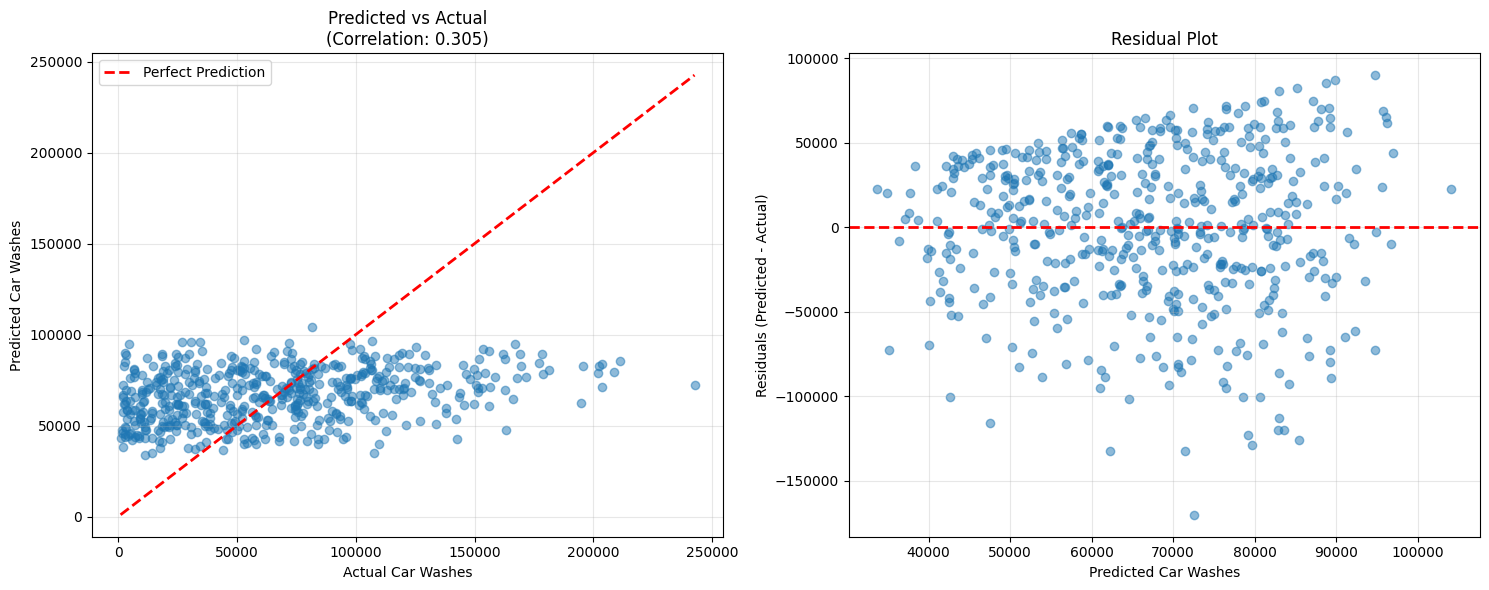

In [38]:
# Visualize predictions vs actuals
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Scatter plot
axes[0].scatter(y, y_pred_cv, alpha=0.5)
axes[0].plot([y.min(), y.max()], [y.min(), y.max()], 'r--', lw=2, label='Perfect Prediction')
axes[0].set_xlabel('Actual Car Washes')
axes[0].set_ylabel('Predicted Car Washes')
axes[0].set_title(f'Predicted vs Actual\n(Correlation: {correlation:.3f})')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Residual plot
residuals = y_pred_cv - y
axes[1].scatter(y_pred_cv, residuals, alpha=0.5)
axes[1].axhline(y=0, color='r', linestyle='--', lw=2)
axes[1].set_xlabel('Predicted Car Washes')
axes[1].set_ylabel('Residuals (Predicted - Actual)')
axes[1].set_title('Residual Plot')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

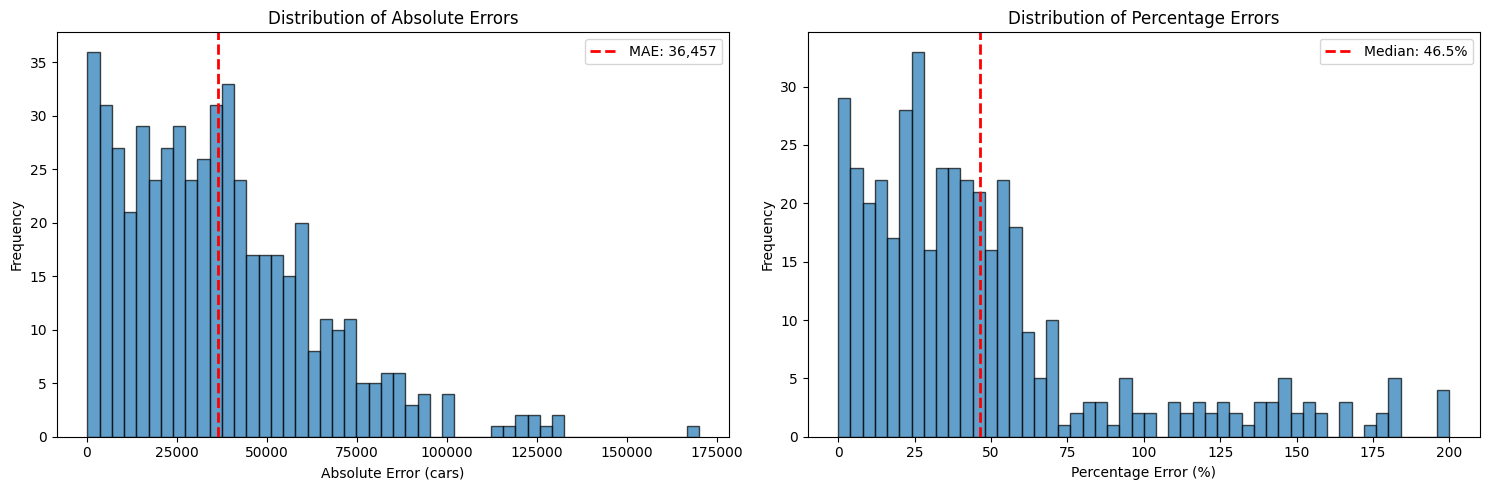

Median absolute error: 32,683 cars
Median percentage error: 46.5%


In [39]:
# Error distribution
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Absolute errors
abs_errors = np.abs(y - y_pred_cv)
axes[0].hist(abs_errors, bins=50, edgecolor='black', alpha=0.7)
axes[0].axvline(mae, color='red', linestyle='--', lw=2, label=f'MAE: {mae:,.0f}')
axes[0].set_xlabel('Absolute Error (cars)')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Absolute Errors')
axes[0].legend()

# Percentage errors
axes[1].hist(errors_pct, bins=50, edgecolor='black', alpha=0.7, range=(0, 200))
axes[1].axvline(np.median(errors_pct), color='red', linestyle='--', lw=2, 
                label=f'Median: {np.median(errors_pct):.1f}%')
axes[1].set_xlabel('Percentage Error (%)')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Distribution of Percentage Errors')
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"Median absolute error: {np.median(abs_errors):,.0f} cars")
print(f"Median percentage error: {np.median(errors_pct):.1f}%")

In [41]:
# Error rates by volume segment
print("="*80)
print("ERROR RATES BY VOLUME SEGMENT")
print("="*80)

segments = [
    ('Small (<30K)', y < 30000),
    ('Medium (30-70K)', (y >= 30000) & (y < 70000)),
    ('Large (70-120K)', (y >= 70000) & (y < 120000)),
    ('Very Large (>120K)', y >= 120000)
]

print(f"\n{'Segment':<20} {'Count':>8} {'Median Error':>15} {'75th %ile Error':>18}")
print("-"*70)

for seg_name, mask in segments:
    if mask.sum() > 0:
        seg_errors = errors_pct[mask]
        median_err = np.median(seg_errors)
        p75_err = np.percentile(seg_errors, 75)
        count = mask.sum()
        
        # Add visual indicator
        if median_err < 30:
            indicator = "cool"
        elif median_err < 60:
            indicator = "ok"
        else:
            indicator = "bad"
        
        print(f"{seg_name:<20} {count:>8} {median_err:>14.1f}% {p75_err:>17.1f}% {indicator}")

ERROR RATES BY VOLUME SEGMENT

Segment                 Count    Median Error    75th %ile Error
----------------------------------------------------------------------
Small (<30K)              150          315.5%             709.5% bad
Medium (30-70K)           148           31.8%              59.6% ok
Large (70-120K)           162           24.0%              35.6% cool
Very Large (>120K)         71           51.7%              58.2% ok


---
## 6. Feature Importance <a id='features'></a>

In [42]:
# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_processed.columns,
    'importance': model.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("="*80)
print("TOP 20 MOST IMPORTANT FEATURES")
print("="*80)
print(f"\n{'Rank':<6} {'Feature':<50} {'Importance':>12}")
print("-"*70)

for i, row in feature_importance.head(20).iterrows():
    print(f"{i+1:<6} {row['feature']:<50} {row['importance']:>11.4f}")

TOP 20 MOST IMPORTANT FEATURES

Rank   Feature                                              Importance
----------------------------------------------------------------------
1      tunnel_length (in ft.)                                  0.2996
2      distance_nearest_traffic_light_2                        0.0497
3      total_sunshine_hours                                    0.0458
4      2nd Nearest StreetLight US Hourly-Ttl AADT              0.0356
5      days_pleasant_temp                                      0.0348
6      distance_from_nearest_walmart                           0.0348
7      Nearest StreetLight US Hourly-ttl_overnight             0.0342
8      total_precipitation_mm                                  0.0327
9      total_weekly_operational_hours                          0.0313
10     5th Nearest StreetLight US Hourly-Ttl AADT              0.0269
11     distance_nearest_traffic_light_9                        0.0222
12     distance_nearest_traffic_light_4                 

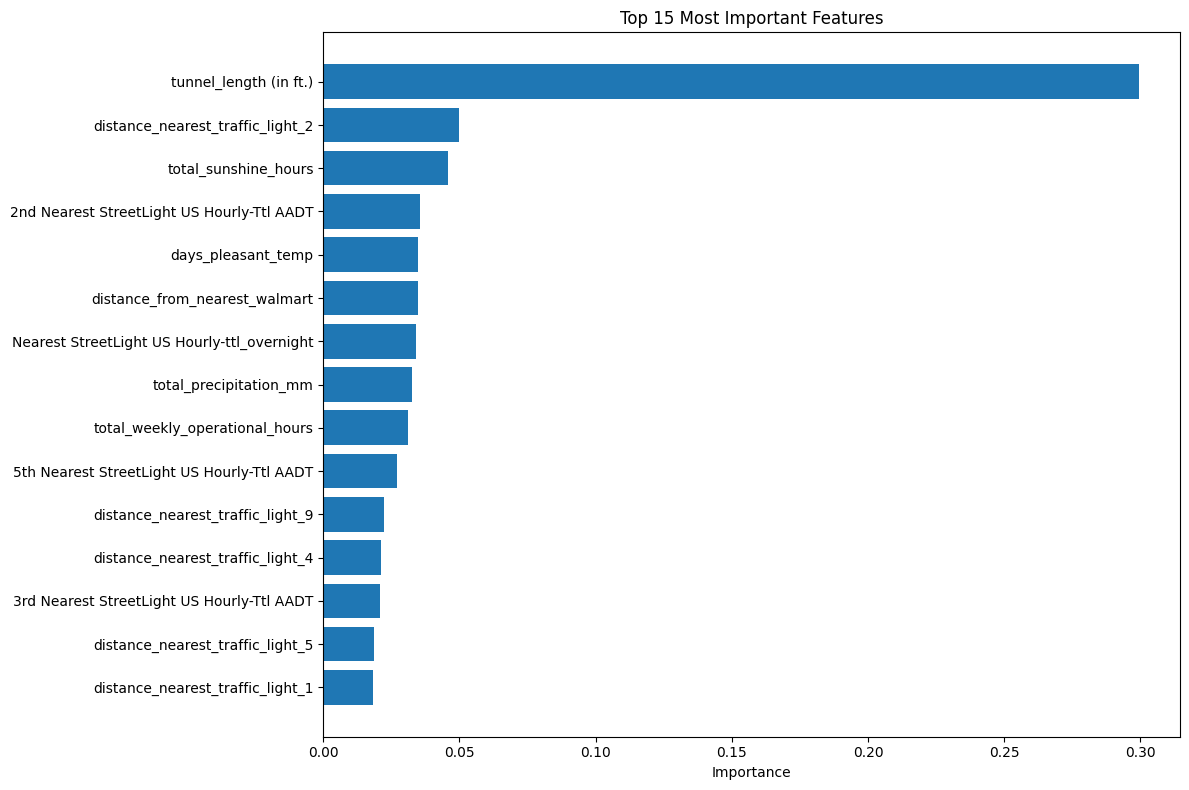


💡 KEY INSIGHT: tunnel_length (in ft.) is the most important feature
   with 30.0% importance!


In [ ]:
# Visualize top features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(range(len(top_features)), top_features['importance'])
plt.yticks(range(len(top_features)), top_features['feature'])
plt.xlabel('Importance')
plt.title('Top 15 Most Important Features')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print(f"\nKEY INSIGHT: {feature_importance.iloc[0]['feature']} is the most important feature")
print(f"   with {feature_importance.iloc[0]['importance']*100:.1f}% importance!")

---
## 7. SHAP-Style Explanations <a id='shap'></a>

For each prediction, we show which features pushed the prediction up or down.

In [ ]:
def explain_prediction(model, X_data, idx, top_n=10):
    """
    SHAP-style explanation showing top features for a specific prediction
    
    Parameters:
    -----------
    model : trained model
    X_data : feature dataframe
    idx : index of sample to explain
    top_n : number of top features to show
    
    Returns:
    --------
    dict with prediction and top features
    """

    sample = X_data.iloc[[idx]]
    prediction = model.predict(sample)[0]
    

    importance = pd.DataFrame({
        'feature': X_data.columns,
        'importance': model.feature_importances_,
        'value': sample.iloc[0].values
    }).sort_values('importance', ascending=False)
    
    # Get average values for comparison
    importance['avg_value'] = X_data.mean().values
    importance['diff_pct'] = ((importance['value'] - importance['avg_value']) / 
                              (importance['avg_value'] + 0.1)) * 100
    
    return {
        'prediction': prediction,
        'top_features': importance.head(top_n),
        'differentiators': importance.nlargest(top_n, 'diff_pct', keep='all')
    }

print("Explanation function defined")

✅ Explanation function defined


In [ ]:
# Example: Explain a few predictions
print("="*100)
print("SAMPLE PREDICTIONS WITH EXPLANATIONS")
print("="*100)

# Pick 3 diverse samples
sample_indices = [
    np.argmin(np.abs(y - y.quantile(0.25))),  # Low volume
    np.argmin(np.abs(y - y.quantile(0.50))),  # Medium volume
    np.argmin(np.abs(y - y.quantile(0.75))),  # High volume
]

for i, idx in enumerate(sample_indices):
    print(f"\n{'─'*100}")
    print(f"EXAMPLE {i+1}/3 - {df.iloc[idx]['full_site_address'][:70]}")
    print(f"{'─'*100}")
    
    actual = y.iloc[idx]
    predicted = y_pred_cv[idx]
    error = predicted - actual
    error_pct = (error / actual) * 100
    
    print(f"\nPerformance:")
    print(f"   Actual:     {actual:>10,.0f} cars/year")
    print(f"   Predicted:  {predicted:>10,.0f} cars/year")
    print(f"   Error:      {error:>+10,.0f} ({error_pct:>+6.1f}%)")
    
    # Get explanation
    explanation = explain_prediction(model, X_processed, idx, top_n=5)
    
    print(f"\nTOP 5 MOST IMPORTANT FEATURES:")
    print(f"   {'Feature':<48} {'Value':>15} {'Importance':>12}")
    print(f"   {'-'*78}")
    
    for j, row in explanation['top_features'].iterrows():
        val = row['value']
        val_str = f"{val:,.1f}" if val > 1 else f"{val:.3f}"
        print(f"   {row['feature']:<48} {val_str:>15} {row['importance']:>11.4f}")

SAMPLE PREDICTIONS WITH EXPLANATIONS

────────────────────────────────────────────────────────────────────────────────────────────────────
EXAMPLE 1/3 - fenton , 3709 owen rd , fenton , mi , 48430
────────────────────────────────────────────────────────────────────────────────────────────────────

📊 Performance:
   Actual:         25,365 cars/year
   Predicted:      71,696 cars/year
   Error:         +46,331 (+182.7%)

✅ TOP 5 MOST IMPORTANT FEATURES:
   Feature                                                    Value   Importance
   ------------------------------------------------------------------------------
   tunnel_length (in ft.)                                     122.6      0.2996
   distance_nearest_traffic_light_2                           0.228      0.0497
   total_sunshine_hours                                     2,830.6      0.0458
   2nd Nearest StreetLight US Hourly-Ttl AADT               3,668.0      0.0356
   days_pleasant_temp                                        

---
## 8. Making Predictions <a id='predictions'></a>

How to use the model to predict new locations

In [ ]:
# Save the trained model
model_package = {
    'model': model,
    'feature_names': X_processed.columns.tolist(),
    'training_stats': {
        'n_samples': len(X_processed),
        'n_features': len(X_processed.columns),
        'r2_score': r2,
        'correlation': correlation,
        'mae': mae,
        'within_30_pct': within_30
    }
}

# Save to file
with open('car_wash_model.pkl', 'wb') as f:
    pickle.dump(model_package, f)

print("Model saved to 'car_wash_model.pkl'")
print(f"\nModel Statistics:")
for key, value in model_package['training_stats'].items():
    if isinstance(value, float):
        print(f"  {key}: {value:.4f}")
    else:
        print(f"  {key}: {value}")

✅ Model saved to 'car_wash_model.pkl'

Model Statistics:
  n_samples: 531
  n_features: 50
  r2_score: 0.0928
  correlation: 0.3048
  mae: 36457.2076
  within_30_pct: 33.7100


In [ ]:
# EXAMPLE: Predict for a new location
print("="*100)
print("EXAMPLE: PREDICTING A NEW LOCATION")
print("="*100)

# Take an existing location as an example (in practice, this would be new data)
example_idx = 0
new_location = X_processed.iloc[[example_idx]]

# Make prediction
prediction = model.predict(new_location)[0]

print(f"\nPREDICTION: {prediction:,.0f} cars/year")
print(f"\nExpected Error Range (based on model performance):")
print(f"   Median case (50%): {prediction * 0.545:,.0f} - {prediction * 1.455:,.0f} cars")
print(f"   Conservative (75%): {prediction * 0.25:,.0f} - {prediction * 2.5:,.0f} cars")

print(f"\nKey Features for this location:")
print(f"   Tunnel length:      {new_location['tunnel_length (in ft.)'].iloc[0]:,.1f} ft")
print(f"   Sunshine hours:     {new_location['total_sunshine_hours'].iloc[0]:,.0f} hrs/year")
print(f"   Days pleasant temp: {new_location['days_pleasant_temp'].iloc[0]:,.1f} days")
print(f"   Weekly hours open:  {new_location['total_weekly_operational_hours'].iloc[0]:,.1f} hrs")

EXAMPLE: PREDICTING A NEW LOCATION

🎯 PREDICTION: 50,595 cars/year

📊 Expected Error Range (based on model performance):
   Median case (50%): 27,574 - 73,616 cars
   Conservative (75%): 12,649 - 126,487 cars

📋 Key Features for this location:
   Tunnel length:      0.0 ft
   Sunshine hours:     3,164 hrs/year
   Days pleasant temp: 126.1 days
   Weekly hours open:  57.0 hrs


---
## 9. Production Usage Examples <a id='examples'></a>

In [ ]:
# EXAMPLE 1: Load saved model and make predictions
print("EXAMPLE 1: Loading Saved Model")
print("="*80)

# Load the model
with open('car_wash_model.pkl', 'rb') as f:
    loaded_model_pkg = pickle.load(f)

loaded_model = loaded_model_pkg['model']
feature_names = loaded_model_pkg['feature_names']

print(f"Model loaded successfully")
print(f"   Features required: {len(feature_names)}")
print(f"   Model type: {type(loaded_model).__name__}")
print(f"   Training performance: {loaded_model_pkg['training_stats']['correlation']*100:.1f}% correlation")

EXAMPLE 1: Loading Saved Model
✅ Model loaded successfully
   Features required: 50
   Model type: RandomForestRegressor
   Training performance: 30.5% correlation


In [49]:
# EXAMPLE 2: Batch predictions for multiple locations
print("\nEXAMPLE 2: Batch Predictions")
print("="*80)

# Select 5 random locations
sample_locations = X_processed.sample(n=5, random_state=42)
sample_actuals = y.loc[sample_locations.index]

# Make predictions
batch_predictions = loaded_model.predict(sample_locations)

# Create results dataframe
results = pd.DataFrame({
    'Location': df.loc[sample_locations.index, 'full_site_address'],
    'Predicted': batch_predictions,
    'Actual': sample_actuals,
    'Error': batch_predictions - sample_actuals,
    'Error_%': ((batch_predictions - sample_actuals) / sample_actuals * 100)
})

print("\nBatch Prediction Results:")
print(results.to_string(index=False))

print(f"\nAverage prediction: {batch_predictions.mean():,.0f} cars/year")
print(f"Average error: {np.abs(results['Error_%']).mean():.1f}%")


EXAMPLE 2: Batch Predictions

Batch Prediction Results:
                                                                  Location  Predicted  Actual     Error  Error_%
                rock island express , 1665 denmark rd , union , mo , 63084   63897.29   64111   -213.71    -0.33
jj's car wash friendswood , 2221 w parkwood ave , friendswood , tx , 77546   82103.98  103730 -21626.02   -20.85
      superior tomball carwash , 27840 tomball pkwy , tomball , tx , 77375   84326.06   57295  27031.06    47.18
                    wash it dean , 750 cincinnati ave , xenia , oh , 45385   70903.89   48129  22774.89    47.32
                       magic defiance , 8715 oh-66 , defiance , oh , 43512   41994.61   30804  11190.61    36.33

Average prediction: 68,645 cars/year
Average error: 30.4%


In [50]:
# EXAMPLE 3: Comparing multiple candidate sites
print("\nEXAMPLE 3: Site Selection - Ranking Candidates")
print("="*80)

# Select 5 diverse locations as "candidates"
candidates = X_processed.sample(n=5, random_state=123)
candidate_names = ['Site A', 'Site B', 'Site C', 'Site D', 'Site E']

# Predict
candidate_predictions = loaded_model.predict(candidates)

# Create ranking
ranking = pd.DataFrame({
    'Site': candidate_names,
    'Predicted_Volume': candidate_predictions,
    'Conservative_Low': candidate_predictions * 0.545,  # Median error
    'Conservative_High': candidate_predictions * 1.455,
}).sort_values('Predicted_Volume', ascending=False).reset_index(drop=True)

ranking['Rank'] = range(1, len(ranking) + 1)

print("\nSite Ranking (Best to Worst):")
print(ranking[['Rank', 'Site', 'Predicted_Volume', 'Conservative_Low', 'Conservative_High']].to_string(index=False))

print(f"\n💡 RECOMMENDATION: {ranking.iloc[0]['Site']} predicted to perform best")
print(f"   Expected volume: {ranking.iloc[0]['Predicted_Volume']:,.0f} cars/year")
print(f"   Conservative range: {ranking.iloc[0]['Conservative_Low']:,.0f} - {ranking.iloc[0]['Conservative_High']:,.0f}")


EXAMPLE 3: Site Selection - Ranking Candidates

Site Ranking (Best to Worst):
 Rank   Site  Predicted_Volume  Conservative_Low  Conservative_High
    1 Site E          71999.21          39239.57          104758.85
    2 Site D          70185.09          38250.88          102119.31
    3 Site A          61846.88          33706.55           89987.22
    4 Site C          48567.68          26469.38           70665.97
    5 Site B          48475.02          26418.89           70531.15

💡 RECOMMENDATION: Site E predicted to perform best
   Expected volume: 71,999 cars/year
   Conservative range: 39,240 - 104,759


In [51]:
# EXAMPLE 4: Creating a synthetic location for testing
print("\nEXAMPLE 4: Predicting a Synthetic Location")
print("="*80)

# Create a synthetic location with specific characteristics
# Using average values as baseline
synthetic_location = X_processed.mean().to_frame().T

# Modify key features to create a "good" location
synthetic_location['tunnel_length (in ft.)'] = 120  # Good tunnel
synthetic_location['total_sunshine_hours'] = 3500   # Lots of sunshine
synthetic_location['days_pleasant_temp'] = 200      # Great weather
synthetic_location['total_weekly_operational_hours'] = 84  # Open often

# Predict
synthetic_pred = loaded_model.predict(synthetic_location)[0]

print("\nSynthetic Location Characteristics:")
print(f"  Tunnel length:      120 ft (above average)")
print(f"  Sunshine hours:     3,500 hrs/year (above average)")
print(f"  Pleasant days:      200 days (above average)")
print(f"  Hours open/week:    84 hrs (half time)")

print(f"\n🎯 PREDICTED VOLUME: {synthetic_pred:,.0f} cars/year")
print(f"\n📊 Confidence Range:")
print(f"   Typical case:  {synthetic_pred*0.545:,.0f} - {synthetic_pred*1.455:,.0f} cars")
print(f"   Conservative:  {synthetic_pred*0.25:,.0f} - {synthetic_pred*2.5:,.0f} cars")


EXAMPLE 4: Predicting a Synthetic Location

Synthetic Location Characteristics:
  Tunnel length:      120 ft (above average)
  Sunshine hours:     3,500 hrs/year (above average)
  Pleasant days:      200 days (above average)
  Hours open/week:    84 hrs (half time)

🎯 PREDICTED VOLUME: 70,354 cars/year

📊 Confidence Range:
   Typical case:  38,343 - 102,365 cars
   Conservative:  17,589 - 175,886 cars



EXAMPLE 5: Sensitivity Analysis - Impact of Tunnel Length

Impact of Tunnel Length (all other features constant):
 Tunnel_Length_ft  Predicted_Volume  Change_vs_No_Tunnel
                0          46379.66                 0.00
               50          46728.77               349.11
              100          47109.18               729.52
              150          65471.27             19091.61
              200          65471.27             19091.61
              250          65471.27             19091.61


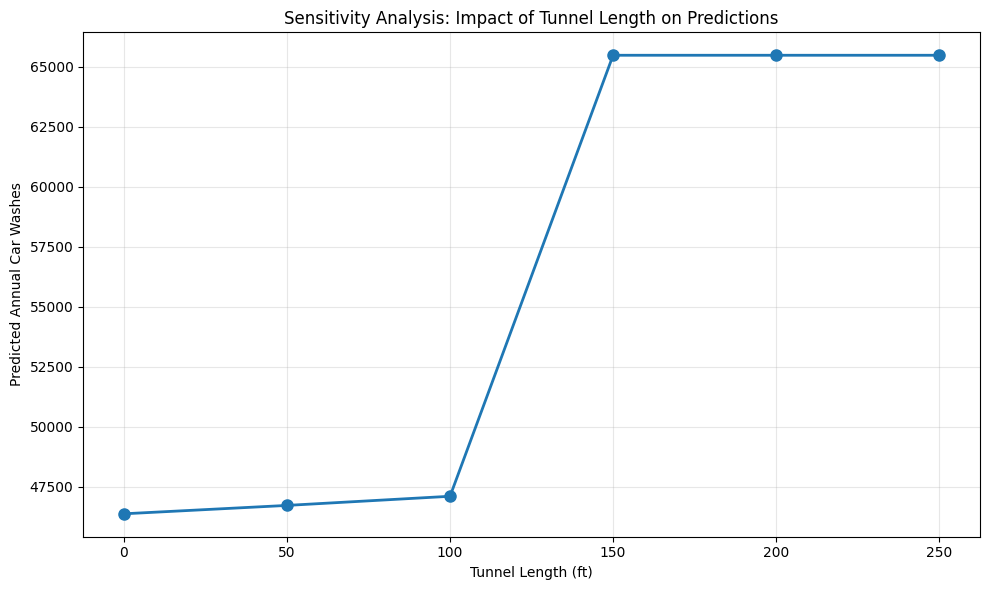


💡 INSIGHT: Adding a 100ft tunnel increases predicted volume by:
   730 cars/year
   (1.6% increase)


In [52]:
# EXAMPLE 5: Sensitivity Analysis - What if we change tunnel length?
print("\nEXAMPLE 5: Sensitivity Analysis - Impact of Tunnel Length")
print("="*80)

# Use an average location as baseline
baseline = X_processed.mean().to_frame().T.copy()

# Test different tunnel lengths
tunnel_lengths = [0, 50, 100, 150, 200, 250]
predictions_by_tunnel = []

for length in tunnel_lengths:
    test_location = baseline.copy()
    test_location['tunnel_length (in ft.)'] = length
    pred = loaded_model.predict(test_location)[0]
    predictions_by_tunnel.append(pred)

# Show results
sensitivity_df = pd.DataFrame({
    'Tunnel_Length_ft': tunnel_lengths,
    'Predicted_Volume': predictions_by_tunnel,
    'Change_vs_No_Tunnel': [p - predictions_by_tunnel[0] for p in predictions_by_tunnel]
})

print("\nImpact of Tunnel Length (all other features constant):")
print(sensitivity_df.to_string(index=False))

# Visualize
plt.figure(figsize=(10, 6))
plt.plot(tunnel_lengths, predictions_by_tunnel, marker='o', linewidth=2, markersize=8)
plt.xlabel('Tunnel Length (ft)')
plt.ylabel('Predicted Annual Car Washes')
plt.title('Sensitivity Analysis: Impact of Tunnel Length on Predictions')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"\n💡 INSIGHT: Adding a 100ft tunnel increases predicted volume by:")
print(f"   {sensitivity_df.loc[2, 'Change_vs_No_Tunnel']:,.0f} cars/year")
print(f"   ({sensitivity_df.loc[2, 'Change_vs_No_Tunnel']/predictions_by_tunnel[0]*100:.1f}% increase)")